<a href="https://colab.research.google.com/github/Deepak-Mewada/DL-for-EEG-based-BCI/blob/main/ReptileEEG_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install moabb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 140 kB 7.8 MB/s 
     |████████████████████████████████| 365 kB 39.4 MB/s 
     |████████████████████████████████| 636 kB 42.4 MB/s 
     |████████████████████████████████| 242 kB 59.9 MB/s 
     |████████████████████████████████| 7.6 MB 48.7 MB/s 
  Created wheel for pyriemann: filename=pyriemann-0.3-py2.py3-none-any.whl size=78033 sha256=d79751ddd76edcc12c266b2e6c50b5ee6d4d5b774d4dd0cdfb65ed24608b415f
  Stored in directory: /root/.cache/pip/wheels/0b/1b/bf/a537f9e17e6c3490004ede419c72f863af1d0d765d25e532ef
Successfully built pyriemann
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 6.0
    Uninstalling PyYAML-6.0:
      Successfully uninstalled PyYAML-6.0


In [ ]:

# import tempfile

# from braindecode.datasets import MOABBDataset
# from braindecode.preprocessing import preprocess, Preprocessor
# from braindecode.datautil import load_concat_dataset
# from braindecode.preprocessing import create_windows_from_events
from moabb.datasets import BNCI2014001, Cho2017, PhysionetMI
from moabb.paradigms import MotorImagery

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds


In [ ]:
#ds_src1 = Cho2017()
#ds_src2 = PhysionetMI()
ds_tgt = BNCI2014001()

fmin, fmax = 4, 32
raw = ds_tgt.get_data(subjects=[1])[1]['session_T']['run_1']
tgt_channels = raw.pick_types(eeg=True).ch_names
sfreq = 250.
#prgm_2classes = MotorImagery(n_classes=2, channels=tgt_channels, resample=sfreq, fmin=fmin, fmax=fmax)
prgm_4classes = MotorImagery(n_classes=4, channels=tgt_channels, resample=sfreq, fmin=fmin, fmax=fmax)

#X_src1, label_src1, m_src1 = prgm_2classes.get_data(dataset=ds_src1, subjects=[1, 2, 3])
#X_src2, label_src2, m_src2 = prgm_4classes.get_data(dataset=ds_src2, subjects=[1, 2, 3, 4, 5])
X_tgt, label_tgt, m_tgt = prgm_4classes.get_data(dataset=ds_tgt, subjects=[1,2,3,4,5,6,7,8,9])

#print("First source dataset has {} trials with {} electrodes and {} time samples".format(*X_src1.shape))
#print("Second source dataset has {} trials with {} electrodes and {} time samples".format(*X_src2.shape))
print("Target dataset has {} trials with {} electrodes and {} time samples".format(*X_tgt.shape))

#print ("\nSource dataset 1 include labels: {}".format(np.unique(label_src1)))
#print ("Source dataset 2 include labels: {}".format(np.unique(label_src2)))
print ("Target dataset 1 include labels: {}".format(np.unique(label_tgt)))

/usr/local/lib/python3.7/dist-packages/moabb/datasets/download.py:53: RuntimeWarning: Setting non-standard config type: "MNE_DATASETS_BNCI_PATH"
  set_config(key, get_config("MNE_DATA"))


MNE_DATA is not already configured. It will be set to default location in the home directory - /root/mne_data
All datasets will be downloaded to this location, if anything is already downloaded, please move manually to this location


100%|█████████████████████████████████████| 42.8M/42.8M [00:00<00:00, 5.03GB/s]
SHA256 hash of downloaded file: 054f02e70cf9c4ada1517e9b9864f45407939c1062c6793516585c6f511d0325
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.
100%|█████████████████████████████████████| 43.8M/43.8M [00:00<00:00, 5.16GB/s]
SHA256 hash of downloaded file: 53d415f39c3d7b0c88b894d7b08d99bcdfe855ede63831d3691af1a45607fb62
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.
100%|█████████████████████████████████████| 43.1M/43.1M [00:00<00:00, 13.8GB/s]
SHA256 hash of downloaded file: 5ddd5cb520b1692c3ba1363f48d98f58f0e46f3699ee50d749947950fc39db27
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.
100%|████████████████████████████████

Target dataset has 5184 trials with 22 electrodes and 1001 time samples
Target dataset 1 include labels: ['feet' 'left_hand' 'right_hand' 'tongue']


In [ ]:
# X_tgt, label_tgt, 
X_tgt.shape

(5184, 22, 1001)

In [ ]:
label_tgt.shape

(5184,)

In [ ]:
X_train = np.random.rand(100, 1, 120, 64).astype('float32') # np.random.rand generates between [0, 1)
y_train = np.round(np.random.rand(100).astype('float32')) # binary data, so we round it to 0 or 1.

X_val = np.random.rand(100, 1, 120, 64).astype('float32')
y_val = np.round(np.random.rand(100).astype('float32'))

X_test = np.random.rand(100, 1, 120, 64).astype('float32')
y_test = np.round(np.random.rand(100).astype('float32'))

In [ ]:
X_train.shape

(100, 1, 120, 64)

## Define the Hyperparameters


In [ ]:
learning_rate = 0.003
meta_step_size = 0.25

inner_batch_size = 25
eval_batch_size = 25

meta_iters = 500#2000
eval_iters = 5
inner_iters = 4

eval_interval = 1
train_shots = 20
shots = 5
classes = 4


## Prepare the data

The [Omniglot dataset](https://github.com/brendenlake/omniglot/) is a dataset of 1,623
characters taken from 50 different alphabets, with 20 examples for each character.
The 20 samples for each character were drawn online via Amazon's Mechanical Turk. For the
few-shot learning task, `k` samples (or "shots") are drawn randomly from `n` randomly-chosen
classes. These `n` numerical values are used to create a new set of temporary labels to use
to test the model's ability to learn a new task given few examples. In other words, if you
are training on 5 classes, your new class labels will be either 0, 1, 2, 3, or 4.
Omniglot is a great dataset for this task since there are many different classes to draw
from, with a reasonable number of samples for each class.


In [ ]:
for i in range(label_tgt.shape[0]) :
  image=np.array(X_tgt[i]).reshape(22,1001,1)
  label=label_tgt[i]
  print(image.shape,label)

In [ ]:

class Dataset_moabb:
    # This class will facilitate the creation of a few-shot dataset
    # from the Omniglot dataset that can be sampled from quickly while also
    # allowing to create new labels at the same time.
    def __init__(self, training):
        # Download the tfrecord files containing the omniglot data and convert to a
        # dataset.
          # split = "train" if training else "test"
          # ds = tfds.load("omniglot", split=split, as_supervised=True, shuffle_files=False)
          # # Iterate over the dataset to get each individual image and its class,
          # # and put that data into a dictionary.
        ds_tgt = BNCI2014001()

        fmin, fmax = 4, 32
        raw = ds_tgt.get_data(subjects=[1])[1]['session_T']['run_1']
        tgt_channels = raw.pick_types(eeg=True).ch_names
        sfreq = 250.
        prgm_4classes = MotorImagery(n_classes=4, channels=tgt_channels, resample=sfreq, fmin=fmin, fmax=fmax)

        X_tgt, label_tgt, m_tgt = prgm_4classes.get_data(dataset=ds_tgt, subjects=[1,2,3,4,5,6,7,8,9])

        self.data = {}

        for i in range(label_tgt.shape[0]) :
            image=np.array(X_tgt[i]).reshape(22,1001,1)
            label=label_tgt[i]
            label = str(label)
            if label not in self.data:
                self.data[label] = []
            self.data[label].append(image)
        self.labels = list(self.data.keys())

    def get_mini_dataset(
        self, batch_size, repetitions, shots, num_classes, split=False
    ):
        temp_labels = np.zeros(shape=(num_classes * shots))
        temp_images = np.zeros(shape=(num_classes * shots, 22, 1001, 1))
        if split:
            test_labels = np.zeros(shape=(num_classes))
            test_images = np.zeros(shape=(num_classes, 22, 1001, 1))

        # Get a random subset of labels from the entire label set.
        label_subset = random.choices(self.labels, k=num_classes)
        for class_idx, class_obj in enumerate(label_subset):
            # Use enumerated index value as a temporary label for mini-batch in
            # few shot learning.
            temp_labels[class_idx * shots : (class_idx + 1) * shots] = class_idx
            # If creating a split dataset for testing, select an extra sample from each
            # label to create the test dataset.
            if split:
                test_labels[class_idx] = class_idx
                images_to_split = random.choices(
                    self.data[label_subset[class_idx]], k=shots + 1
                )
                test_images[class_idx] = images_to_split[-1]
                temp_images[
                    class_idx * shots : (class_idx + 1) * shots
                ] = images_to_split[:-1]
            else:
                # For each index in the randomly selected label_subset, sample the
                # necessary number of images.
                temp_images[
                    class_idx * shots : (class_idx + 1) * shots
                ] = random.choices(self.data[label_subset[class_idx]], k=shots)

        dataset = tf.data.Dataset.from_tensor_slices(
            (temp_images.astype(np.float32), temp_labels.astype(np.int32))
        )
        dataset = dataset.shuffle(100).batch(batch_size).repeat(repetitions)
        if split:
            return dataset, test_images, test_labels
        return dataset


import urllib3

urllib3.disable_warnings()  # Disable SSL warnings that may happen during download.
train_dataset_moabb = Dataset_moabb(training=True)
test_dataset_moabb = Dataset_moabb(training=False)


In [ ]:
np.array(train_dataset_moabb.data['left_hand']).shape

(1296, 22, 1001, 1)

In [ ]:
train_dataset_moabb.labels

['tongue', 'feet', 'right_hand', 'left_hand']

In [ ]:
len(train_dataset_moabb.data.keys())

4

In [ ]:
len(test_dataset_moabb.data.keys())

4

In [ ]:

# class Dataset:
#     # This class will facilitate the creation of a few-shot dataset
#     # from the Omniglot dataset that can be sampled from quickly while also
#     # allowing to create new labels at the same time.
#     def __init__(self, training):
#         # Download the tfrecord files containing the omniglot data and convert to a
#         # dataset.
#         split = "train" if training else "test"
#         ds = tfds.load("omniglot", split=split, as_supervised=True, shuffle_files=False)
#         # Iterate over the dataset to get each individual image and its class,
#         # and put that data into a dictionary.
#         self.data = {}

#         def extraction(image, label):
#             # This function will shrink the Omniglot images to the desired size,
#             # scale pixel values and convert the RGB image to grayscale
#             image = tf.image.convert_image_dtype(image, tf.float32)
#             image = tf.image.rgb_to_grayscale(image)
#             image = tf.image.resize(image, [28, 28])
#             return image, label

#         for image, label in ds.map(extraction):
#             image = image.numpy()
#             label = str(label.numpy())
#             if label not in self.data:
#                 self.data[label] = []
#             self.data[label].append(image)
#         self.labels = list(self.data.keys())

#     def get_mini_dataset(
#         self, batch_size, repetitions, shots, num_classes, split=False
#     ):
#         temp_labels = np.zeros(shape=(num_classes * shots))
#         temp_images = np.zeros(shape=(num_classes * shots, 28, 28, 1))
#         if split:
#             test_labels = np.zeros(shape=(num_classes))
#             test_images = np.zeros(shape=(num_classes, 28, 28, 1))

#         # Get a random subset of labels from the entire label set.
#         label_subset = random.choices(self.labels, k=num_classes)
#         for class_idx, class_obj in enumerate(label_subset):
#             # Use enumerated index value as a temporary label for mini-batch in
#             # few shot learning.
#             temp_labels[class_idx * shots : (class_idx + 1) * shots] = class_idx
#             # If creating a split dataset for testing, select an extra sample from each
#             # label to create the test dataset.
#             if split:
#                 test_labels[class_idx] = class_idx
#                 images_to_split = random.choices(
#                     self.data[label_subset[class_idx]], k=shots + 1
#                 )
#                 test_images[class_idx] = images_to_split[-1]
#                 temp_images[
#                     class_idx * shots : (class_idx + 1) * shots
#                 ] = images_to_split[:-1]
#             else:
#                 # For each index in the randomly selected label_subset, sample the
#                 # necessary number of images.
#                 temp_images[
#                     class_idx * shots : (class_idx + 1) * shots
#                 ] = random.choices(self.data[label_subset[class_idx]], k=shots)

#         dataset = tf.data.Dataset.from_tensor_slices(
#             (temp_images.astype(np.float32), temp_labels.astype(np.int32))
#         )
#         dataset = dataset.shuffle(100).batch(batch_size).repeat(repetitions)
#         if split:
#             return dataset, test_images, test_labels
#         return dataset


# import urllib3

# urllib3.disable_warnings()  # Disable SSL warnings that may happen during download.
# train_dataset = Dataset(training=True)
# test_dataset = Dataset(training=False)


In [ ]:
# for img,lab in temp:
#   print(img.shape)
#   print(lab)

## Visualize some examples from the dataset


In [ ]:
# _, axarr = plt.subplots(nrows=5, ncols=5, figsize=(20, 20))

# sample_keys = list(train_dataset.data.keys())

# for a in range(4):
#     for b in range(4):
#         temp_image = train_dataset.data[sample_keys[a]][b]
#         temp_image = np.stack((temp_image[:, :, 0],) * 3, axis=2)
#         temp_image *= 255
#         temp_image = np.clip(temp_image, 0, 255).astype("uint8")
#         if b == 2:
#             axarr[a, b].set_title("Class : " + sample_keys[a])
#         axarr[a, b].imshow(temp_image, cmap="gray")
#         axarr[a, b].xaxis.set_visible(False)
#         axarr[a, b].yaxis.set_visible(False)
# plt.show()


## Build the model


In [ ]:

# def conv_bn(x):
#     x = layers.Conv2D(filters=64, kernel_size=3, strides=2, padding="same")(x)
#     x = layers.BatchNormalization()(x)
#     return layers.ReLU()(x)


# inputs = layers.Input(shape=(28, 28, 1))
# x = conv_bn(inputs)
# x = conv_bn(x)
# x = conv_bn(x)
# x = conv_bn(x)
# x = layers.Flatten()(x)
# outputs = layers.Dense(classes, activation="softmax")(x)
# model = keras.Model(inputs=inputs, outputs=outputs)
# model.compile()
# optimizer = keras.optimizers.SGD(learning_rate=learning_rate)




def conv_bn(x):
    x = layers.Conv2D(filters=64, kernel_size=3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    return layers.ReLU()(x)


inputs = layers.Input(shape=(22, 1001, 1))
x = conv_bn(inputs)
x = conv_bn(x)
x = conv_bn(x)
x = conv_bn(x)
x = layers.Flatten()(x)
outputs = layers.Dense(classes, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile()
optimizer = keras.optimizers.SGD(learning_rate=learning_rate)


## Train the model


learning_rate = 0.003
meta_step_size = 0.25

inner_batch_size = 25
eval_batch_size = 25

meta_iters = 2000
eval_iters = 5
inner_iters = 4

eval_interval = 1
train_shots = 20
shots = 5
classes = 4


In [ ]:
learning_rate = 0.003
meta_step_size = 0.25

inner_batch_size = 25
eval_batch_size = 25

meta_iters = 500#2000
eval_iters = 5
inner_iters = 4

eval_interval = 1
train_shots = 20
shots = 5
classes = 4


In [ ]:
# training = []
# testing = []
# for meta_iter in range(meta_iters):
#     frac_done = meta_iter / meta_iters
#     cur_meta_step_size = (1 - frac_done) * meta_step_size
#     # Temporarily save the weights from the model.
#     old_vars = model.get_weights()
#     # Get a sample from the full dataset.
#     mini_dataset = train_dataset.get_mini_dataset(
#         inner_batch_size, inner_iters, train_shots, classes
#     )
#     for images, labels in mini_dataset:
#         with tf.GradientTape() as tape:
#             preds = model(images)
#             loss = keras.losses.sparse_categorical_crossentropy(labels, preds)
#         grads = tape.gradient(loss, model.trainable_weights)
#         optimizer.apply_gradients(zip(grads, model.trainable_weights))
#     new_vars = model.get_weights()
#     # Perform SGD for the meta step.
#     for var in range(len(new_vars)):
#         new_vars[var] = old_vars[var] + (
#             (new_vars[var] - old_vars[var]) * cur_meta_step_size
#         )
#     # After the meta-learning step, reload the newly-trained weights into the model.
#     model.set_weights(new_vars)
#     # Evaluation loop
#     if meta_iter % eval_interval == 0:
#         accuracies = []
#         for dataset in (train_dataset, test_dataset):
#             # Sample a mini dataset from the full dataset.
#             train_set, test_images, test_labels = dataset.get_mini_dataset(
#                 eval_batch_size, eval_iters, shots, classes, split=True
#             )
#             old_vars = model.get_weights()
#             # Train on the samples and get the resulting accuracies.
#             for images, labels in train_set:
#                 with tf.GradientTape() as tape:
#                     preds = model(images)
#                     loss = keras.losses.sparse_categorical_crossentropy(labels, preds)
#                 grads = tape.gradient(loss, model.trainable_weights)
#                 optimizer.apply_gradients(zip(grads, model.trainable_weights))
#             test_preds = model.predict(test_images)
#             test_preds = tf.argmax(test_preds).numpy()
#             num_correct = (test_preds == test_labels).sum()
#             # Reset the weights after getting the evaluation accuracies.
#             model.set_weights(old_vars)
#             accuracies.append(num_correct / classes)
#         training.append(accuracies[0])
#         testing.append(accuracies[1])
#         if meta_iter % 100 == 0:
#             print(
#                 "batch %d: train=%f test=%f" % (meta_iter, accuracies[0], accuracies[1])
#             )



training = []
testing = []
for meta_iter in range(meta_iters):
    frac_done = meta_iter / meta_iters
    cur_meta_step_size = (1 - frac_done) * meta_step_size
    # Temporarily save the weights from the model.
    old_vars = model.get_weights()
    # Get a sample from the full dataset.
    mini_dataset = train_dataset_moabb.get_mini_dataset(
        inner_batch_size, inner_iters, train_shots, classes
    )
    for images, labels in mini_dataset:
        with tf.GradientTape() as tape:
            preds = model(images)
            loss = keras.losses.sparse_categorical_crossentropy(labels, preds)
        grads = tape.gradient(loss, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
    new_vars = model.get_weights()
    # Perform SGD for the meta step.
    for var in range(len(new_vars)):
        new_vars[var] = old_vars[var] + (
            (new_vars[var] - old_vars[var]) * cur_meta_step_size
        )
    # After the meta-learning step, reload the newly-trained weights into the model.
    model.set_weights(new_vars)
    # Evaluation loop
    if meta_iter % eval_interval == 0:
        accuracies = []
        for dataset in (train_dataset_moabb, test_dataset_moabb):
            # Sample a mini dataset from the full dataset.
            train_set, test_images, test_labels = dataset.get_mini_dataset(
                eval_batch_size, eval_iters, shots, classes, split=True
            )
            old_vars = model.get_weights()
            # Train on the samples and get the resulting accuracies.
            for images, labels in train_set:
                with tf.GradientTape() as tape:
                    preds = model(images)
                    loss = keras.losses.sparse_categorical_crossentropy(labels, preds)
                grads = tape.gradient(loss, model.trainable_weights)
                optimizer.apply_gradients(zip(grads, model.trainable_weights))
            test_preds = model.predict(test_images)
            test_preds = tf.argmax(test_preds).numpy()
            num_correct = (test_preds == test_labels).sum()
            # Reset the weights after getting the evaluation accuracies.
            model.set_weights(old_vars)
            accuracies.append(num_correct / classes)
        training.append(accuracies[0])
        testing.append(accuracies[1])
        if meta_iter % 100 == 0:
            print(
                "batch %d: train=%f test=%f" % (meta_iter, accuracies[0], accuracies[1])
            )


1/1 [==============================] - 0s 38ms/step
batch 0: train=0.250000 test=0.250000
1/1 [==============================] - 0s 39ms/step
batch 100: train=0.250000 test=0.000000
1/1 [==============================] - 0s 42ms/step
batch 200: train=0.250000 test=0.500000
1/1 [==============================] - 0s 40ms/step
batch 300: train=0.000000 test=0.250000
1/1 [==============================] - 0s 41ms/step
batch 400: train=0.750000 test=0.250000
1/1 [==============================] - 0s 40ms/step


In [ ]:
lab_list=['tongue', 'feet', 'right_hand', 'left_hand']
for lab in range(4):
  kk=model.predict(np.array(test_dataset_moabb.data[lab_list[lab]]))
  acc=[]
  for i in kk:
    acc.append(np.argmax(i))
  
  
  


In [ ]:
train_set

<RepeatDataset element_spec=(TensorSpec(shape=(None, 22, 1001, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
test_images.shape#, test_labels.shape

(4, 22, 1001, 1)

In [ ]:
kk=model.predict(test_images)
kk

1/1 [==============================] - 0s 42ms/step


array([[0.48646212, 0.18324555, 0.11430261, 0.2159898 ],
       [0.20345294, 0.32902628, 0.19928552, 0.26823527],
       [0.3316955 , 0.16487516, 0.25347722, 0.24995211],
       [0.23587875, 0.03101721, 0.62462115, 0.10848284]], dtype=float32)

In [ ]:
np.array(test_dataset_moabb.data['tongue']).shape

(1296, 22, 1001, 1)

In [ ]:
test_dataset_moabb.data['tongue'][0].reshape((1,22,1001,1)).shape

(1, 22, 1001, 1)

In [ ]:
np.array(test_dataset_moabb.data['tongue'][0:4]).shape

(4, 22, 1001, 1)

In [ ]:
kk=model.predict(np.array(test_dataset_moabb.data['tongue']))
ans = tf.argmax(kk).numpy()
ans

41/41 [==============================] - 6s 154ms/step


array([   6, 1268, 1153,  339])

In [ ]:
acc=[]
for i in kk:
  acc.append(np.argmax(i))
pd.Series(acc).value_counts()

2    352
1    352
0    324
3    268
dtype: int64

In [ ]:
pd.Series(acc)

2

In [ ]:
kk=model.predict(np.array(test_dataset_moabb.data['feet']))
ans = tf.argmax(kk).numpy()
ans

41/41 [==============================] - 7s 182ms/step


array([ 665, 1277,  791,  811])

In [ ]:
acc=[]
for i in kk:
  acc.append(np.argmax(i))
pd.Series(acc).value_counts()

0    360
2    342
3    307
1    287
dtype: int64

In [ ]:
kk=model.predict(np.array(test_dataset_moabb.data['right_hand']))
ans = tf.argmax(kk).numpy()
ans

41/41 [==============================] - 7s 173ms/step


array([1257,  232,  369, 1093])

In [ ]:
acc=[]
for i in kk:
  acc.append(np.argmax(i))
pd.Series(acc).value_counts()

0    345
3    330
1    321
2    300
dtype: int64

In [ ]:
kk=model.predict(np.array(test_dataset_moabb.data['left_hand']))
ans = tf.argmax(kk).numpy()
ans

41/41 [==============================] - 7s 171ms/step


array([982, 242, 967, 826])

In [ ]:
acc=[]
for i in kk:
  acc.append(np.argmax(i))
pd.Series(acc).value_counts()

3    351
2    329
0    314
1    302
dtype: int64

In [ ]:
test_dataset_moabb.labels

['tongue', 'feet', 'right_hand', 'left_hand']

In [ ]:
test_labels

array([0., 1., 2., 3.])

In [ ]:
import pandas as pd
pd.Series(acc).value_counts()

2    352
1    352
0    324
3    268
dtype: int64

## Visualize Results


1/1 [==============================] - 0s 30ms/step


IndexError: ignored

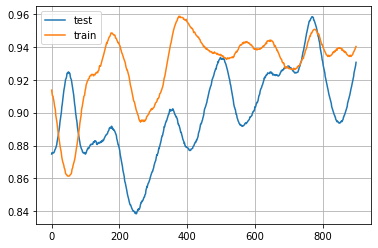

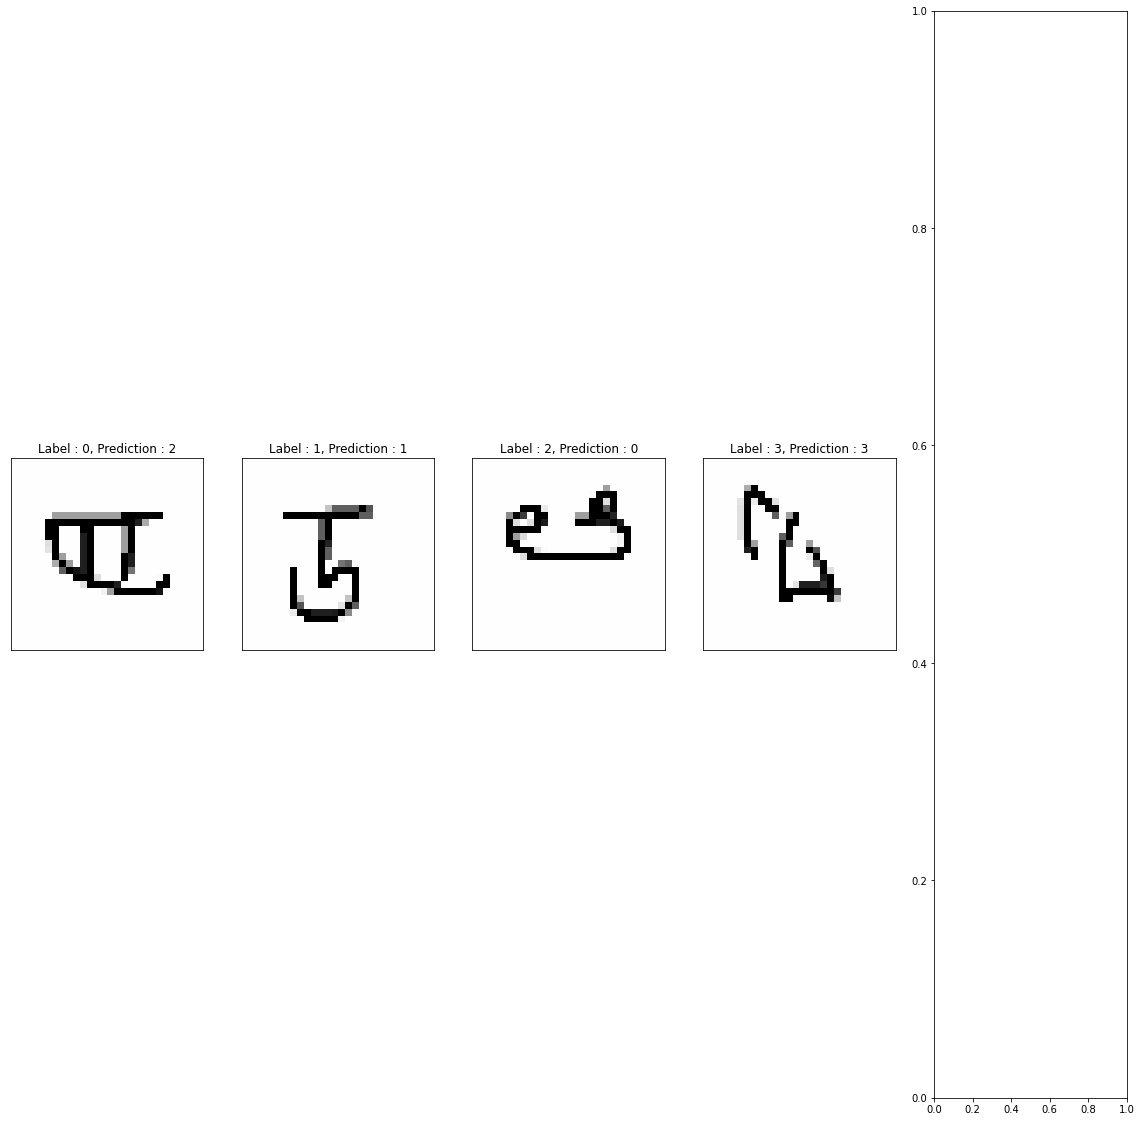

In [ ]:
# First, some preprocessing to smooth the training and testing arrays for display.
window_length = 100
train_s = np.r_[
    training[window_length - 1 : 0 : -1], training, training[-1:-window_length:-1]
]
test_s = np.r_[
    testing[window_length - 1 : 0 : -1], testing, testing[-1:-window_length:-1]
]
w = np.hamming(window_length)
train_y = np.convolve(w / w.sum(), train_s, mode="valid")
test_y = np.convolve(w / w.sum(), test_s, mode="valid")

# Display the training accuracies.
x = np.arange(0, len(test_y), 1)
plt.plot(x, test_y, x, train_y)
plt.legend(["test", "train"])
plt.grid()

train_set, test_images, test_labels = dataset.get_mini_dataset(
    eval_batch_size, eval_iters, shots, classes, split=True
)
for images, labels in train_set:
    with tf.GradientTape() as tape:
        preds = model(images)
        loss = keras.losses.sparse_categorical_crossentropy(labels, preds)
    grads = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
test_preds = model.predict(test_images)
test_preds = tf.argmax(test_preds).numpy()

_, axarr = plt.subplots(nrows=1, ncols=5, figsize=(20, 20))

sample_keys = list(train_dataset.data.keys())

for i, ax in zip(range(5), axarr):
    temp_image = np.stack((test_images[i, :, :, 0],) * 3, axis=2)
    temp_image *= 255
    temp_image = np.clip(temp_image, 0, 255).astype("uint8")
    ax.set_title(
        "Label : {}, Prediction : {}".format(int(test_labels[i]), test_preds[i])
    )
    ax.imshow(temp_image, cmap="gray")
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
plt.show()


In [ ]:
test_dataset.data.keys()

dict_keys(['1550', '1175', '1338', '1457', '1123', '1344', '1602', '1162', '1041', '1428', '1059', '1037', '1580', '1432', '1545', '1146', '1369', '1345', '1105', '1364', '1380', '1330', '1585', '1405', '1604', '998', '1368', '1166', '1235', '1603', '1540', '1250', '1421', '1267', '1388', '1284', '1256', '1436', '1342', '1173', '1159', '1444', '1254', '1080', '976', '1034', '1270', '970', '1318', '1089', '1316', '1446', '1262', '1539', '1464', '1016', '1063', '1093', '1298', '1070', '1239', '1168', '1398', '1197', '1169', '1356', '1384', '1289', '1103', '975', '1563', '1544', '1542', '1324', '1258', '993', '1508', '1413', '1274', '1128', '1042', '1536', '1068', '1535', '1408', '1520', '1210', '1601', '1500', '1121', '1485', '1058', '1100', '991', '1449', '990', '1164', '1620', '972', '1530', '1214', '1438', '1028', '1291', '1418', '1610', '1272', '1608', '1590', '1206', '1135', '1460', '1122', '1466', '1039', '1435', '1054', '1525', '1050', '1521', '1129', '1304', '1136', '1514', '1528